# Food review sentiment analysis
### Authors: Daniel Michalak, Igor Rybakowski

## Load modules

In [214]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.datasets import load_files
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/redcorn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data

In [215]:
import os

for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Food Review Sentiment Analysis.ipynb
./README.md
./.gitignore
./archive.zip
./.ipynb_checkpoints/Food Review Sentiment Analysis-checkpoint.ipynb
./archive/Reviews.csv
./archive/database.sqlite
./archive/hashes.txt
./.git/ORIG_HEAD
./.git/description
./.git/HEAD
./.git/packed-refs
./.git/COMMIT_EDITMSG
./.git/config
./.git/index
./.git/info/exclude
./.git/logs/HEAD
./.git/logs/refs/remotes/origin/five-level
./.git/logs/refs/remotes/origin/HEAD
./.git/logs/refs/remotes/origin/master
./.git/logs/refs/heads/five-level
./.git/logs/refs/heads/master
./.git/refs/remotes/origin/five-level
./.git/refs/remotes/origin/HEAD
./.git/refs/remotes/origin/master
./.git/refs/heads/five-level
./.git/refs/heads/master
./.git/hooks/pre-applypatch.sample
./.git/hooks/prepare-commit-msg.sample
./.git/hooks/pre-commit.sample
./.git/hooks/pre-rebase.sample
./.git/hooks/applypatch-msg.sample
./.git/hooks/update.sample
./.git/hooks/pre-receive.sample
./.git/hooks/commit-msg.sample
./.git/hooks/fsmonitor-watchm

In [216]:
df = pd.read_csv('./archive/Reviews.csv')
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [217]:
len(df)

568454

In [218]:
df.drop(df.tail(500000).index,inplace=True)
len(df)

68454

## Calculate sentiment for every review

In [219]:
df['Sentiment'] = -1
for i,row in df.iterrows():
    val = 0
    if df.at[i,'Score'] > 3:
        val = 1
    df.at[i, 'Sentiment'] = val
    
df = df.drop(['HelpfulnessNumerator', 'Id', 'HelpfulnessDenominator', 'Time',
        'ProductId', 'UserId', 'ProfileName', 'Summary', 'Score'], axis = 1)
df.head(10)

Text  Sentiment
0  I have bought several of the Vitality canned d...          1
1  Product arrived labeled as Jumbo Salted Peanut...          0
2  This is a confection that has been around a fe...          1
3  If you are looking for the secret ingredient i...          0
4  Great taffy at a great price.  There was a wid...          1
5  I got a wild hair for taffy and ordered this f...          1
6  This saltwater taffy had great flavors and was...          1
7  This taffy is so good.  It is very soft and ch...          1
8  Right now I'm mostly just sprouting this so my...          1
9  This is a very healthy dog food. Good for thei...          1

## Calibrate data

In [220]:
df = df.sort_values(by=['Sentiment'])
df.drop(df.tail(30000).index,inplace=True)

## Sentiment comparison

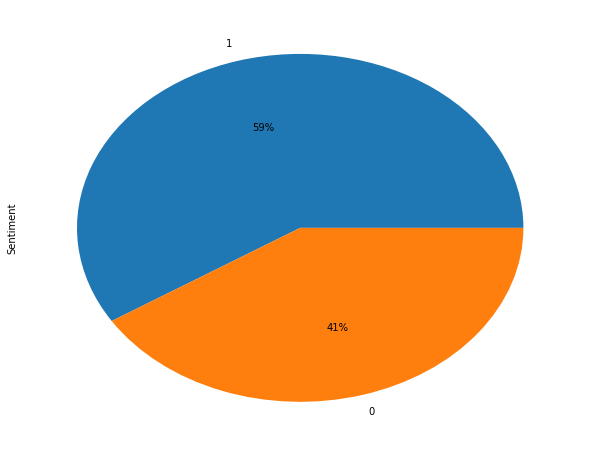

In [222]:
plt.rcParams["figure.figsize"] = [10, 8]
df.Sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%')

In [223]:
len(df)
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_index()
df.head(20)

Text  Sentiment
0   At first I was thinking, "cheese flavored chip...          1
1   I've never had an iced tea that I like better,...          1
2   Before you even consider this, please read [.....          0
3   I love Senseo Coffee, it's convenient, reasona...          1
4   I got this item because the review said it tas...          0
5   First off, I don't own a microwave, so instead...          0
6   First time I've seen my favorite nut in a spre...          0
7   What do they add?  Is it the marshmallow root?...          0
8   So far, Nature Valley Sweet & Salty Nut is the...          1
9   I have been using this trap for 30 years and i...          1
10  Grew like a charm in the window; per reviews f...          1
11  I would never buy this product again because i...          0
12  Dogs loved it and I loved giving them an excel...          1
13  I highly recommend this organic curry powder. ...          1
14  I love <a href="http://www.amazon.com/gp/produ...          1
15  This is the second bag I have purchased. A red...          1
16  Some of these are quite tasty, but all are too...          0
17  My dog had this mastered in less than 5 minute...          0
18  I read all the reviews and I bought this one. ...          1
19  I can't stop eating or buying these. I love th...          1

## Natural language processing

In [224]:
stop = stopwords.words('english')


# Lowering all the letters
df['Text'] = df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Deleting special characters
df['Text'] = df['Text'].str.replace('[^\w\s]','')

# Deleting words from stopwords list
df['Text'] = df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# Deleting frequent words
freq = pd.Series(' '.join(df['Text']).split()).value_counts()[:10]
freq = list(freq.index)
df['Text'] = df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

# Deleting rare words
rare = pd.Series(' '.join(df['Text']).split()).value_counts()[-10:]
rare = list(rare.index)
df['Text'] = df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))

df.head(20)

Text  Sentiment
0   first thinking cheese flavored chips love herb...          1
1   ive never iced better love iced make iced make...          1
2   even consider please read video australia horr...          0
3   love senseo convenient reasonably priced taste...          1
4   got item review said tasted easier used use ho...          0
5   first dont microwave instead nuking 3 12 minut...          0
6   first time ive seen favorite nut spread disapp...          0
7   add marshmallow root theres stevia sickening s...          0
8   far nature valley sweet salty nut best bar use...          1
9   using trap 30 years always done job trick know...          1
10  grew charm window per reviews others put half ...          1
11  would never buy took much effort get lumps for...          0
12  dogs loved loved giving excellent food relativ...          1
13  highly recommend organic curry powder price or...          1
14  love hrefhttpwwwamazoncomgpproductb000evls2ear...          1
15  second bag purchased red dress occasionsschool...          1
16  quite tasty salty way much sodiumbr cheddar ki...          0
17  dog mastered less 5 minutes takes longer hide ...          0
18  read reviews bought loved wonderful wonderful ...          1
19  cant stop eating buying love cookies little mu...          1

## Parameter extraction

In [225]:
df['word_count'] = df['Text'].apply(lambda x: len(str(x).split(" ")))
df[['Text','word_count']].head()

Text  word_count
0  first thinking cheese flavored chips love herb...          13
1  ive never iced better love iced make iced make...          48
2  even consider please read video australia horr...          38
3  love senseo convenient reasonably priced taste...          12
4  got item review said tasted easier used use ho...          36

In [226]:
df['char_count'] = df['Text'].str.len() ## this also includes spaces
df[['Text','char_count']].head()

Text  char_count
0  first thinking cheese flavored chips love herb...          95
1  ive never iced better love iced make iced make...         305
2  even consider please read video australia horr...         241
3  love senseo convenient reasonably priced taste...          91
4  got item review said tasted easier used use ho...         219

In [234]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['Text'].apply(lambda x: avg_word(x))
df[['Text','avg_word']].head()

Text  avg_word
0  first thinking cheese flavored chips love herb...  6.384615
1  ive never iced better love iced make iced make...  5.375000
2  even consider please read video australia horr...  5.368421
3  love senseo convenient reasonably priced taste...  6.666667
4  got item review said tasted easier used use ho...  5.111111

## Most frequent words

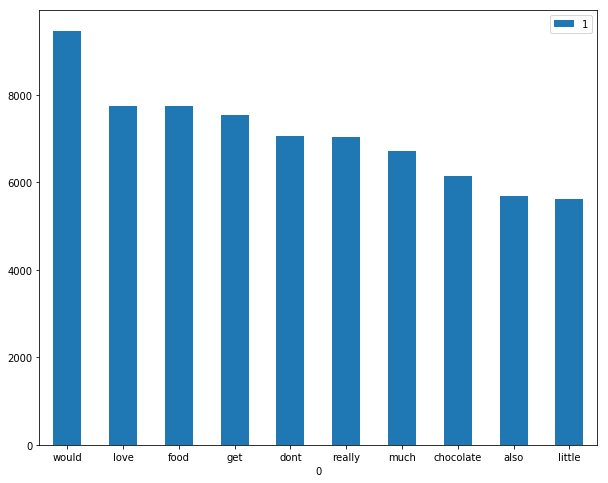

In [227]:
from collections import Counter
most_freq = Counter(" ".join(df["Text"]).split()).most_common(10)
most_freq_df = pd.DataFrame.from_records(most_freq)
most_freq_df.plot.bar(x=0, y=1, rot=0)

## Transforming text to feature vector

In [228]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase = True, analyzer = 'word', stop_words = 'english')
X = df['Text']
y = df['Sentiment']

X = tfidf.fit_transform(X)
X

<38454x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 727205 stored elements in Compressed Sparse Row format>

## Model training & Classification report

In [229]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [230]:
clf = LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [231]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76      3094
           1       0.83      0.87      0.85      4597

    accuracy                           0.82      7691
   macro avg       0.81      0.80      0.81      7691
weighted avg       0.81      0.82      0.81      7691



## Test the machine

In [232]:
import unittest

class Review:
    
    def __init__(self, review : str, sentiment : int):
        self.review = review.lower()
        self.sentiment = sentiment
        
    
    def transform(self):
        vector = tfidf.transform([self.review])
        outcome = clf.predict(vector)
        
        if outcome[0] == 1:
            return True
        else:
            return False
        
        
class TestReview(unittest.TestCase):
    
    def test_review(self):
        print("Write the review of the last dish you had. Spare no sarcasm.")
        review = input()
        print("Is review positive or negative [y/n]")
        sent = input()
        
        if sent == 'y':
            sent = True
        else:
            sent = False
            
        rev = Review(review, sent)
        score = rev.transform()
        self.assertEqual(sent, score)
            
        

In [233]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_review (__main__.TestReview) ... 

Write the review of the last dish you had. Spare no sarcasm.
amazing food
Is review positive or negative [y/n]
y


ok

----------------------------------------------------------------------
Ran 1 test in 8.223s

OK
